In [1]:
import os
print(os.getcwd())

/Users/aswinab/Documents/brain-mri-tumor-project


In [2]:
import os
import torch

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

data_raw_path = "./data_raw"   # <- changed
print("Contents of data_raw:", os.listdir(data_raw_path))

Torch version: 2.5.1
CUDA available: False
Contents of data_raw: ['.DS_Store', 'no', 'yes']


In [3]:
classes = ["yes", "no"]

for cls in classes:
    folder = os.path.join(data_raw_path, cls)
    files = [f for f in os.listdir(folder) if not f.startswith(".")]
    print(cls, ":", len(files), "images")

yes : 155 images
no : 98 images


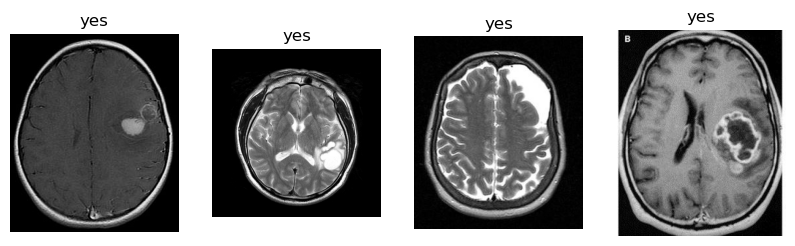

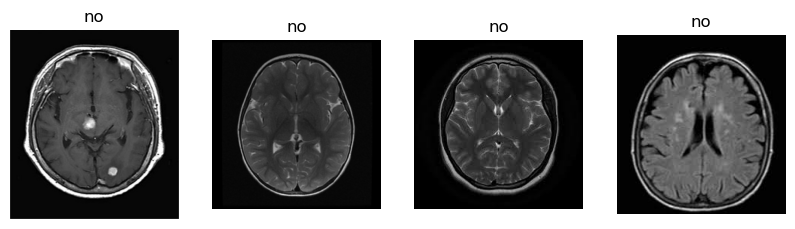

In [4]:
import random
from PIL import Image
import matplotlib.pyplot as plt

def show_random_images(class_name, n=4):
    folder = os.path.join(data_raw_path, class_name)
    files = [f for f in os.listdir(folder) if not f.startswith(".")]
    samples = random.sample(files, min(n, len(files)))
    
    plt.figure(figsize=(10, 5))
    for i, fname in enumerate(samples):
        img_path = os.path.join(folder, fname)
        img = Image.open(img_path)
        plt.subplot(1, len(samples), i + 1)
        plt.imshow(img, cmap="gray")
        plt.title(class_name)
        plt.axis("off")
    plt.show()

show_random_images("yes", n=4)
show_random_images("no", n=4)

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class BrainMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: path to data_raw (containing 'yes' and 'no')
        """
        self.root_dir = root_dir
        self.transform = transform
        
        self.image_paths = []
        self.labels = []

        classes = ["yes", "no"]
        class_to_label = {"yes": 1, "no": 0}

        for cls in classes:
            folder = os.path.join(root_dir, cls)
            for fname in os.listdir(folder):
                if fname.startswith("."):
                    continue  # skip hidden files like .DS_Store
                path = os.path.join(folder, fname)
                self.image_paths.append(path)
                self.labels.append(class_to_label[cls])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")  # ensure 3 channels

        if self.transform:
            img = self.transform(img)

        return img, label

In [6]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

dataset = BrainMRIDataset(root_dir="./data_raw", transform=transform)
print("Total images:", len(dataset))

dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

images, labels = next(iter(dataloader))
print("Batch images shape:", images.shape)
print("Batch labels:", labels)

Total images: 253
Batch images shape: torch.Size([8, 3, 224, 224])
Batch labels: tensor([1, 1, 1, 0, 1, 1, 0, 1])


In [7]:
from sklearn.model_selection import train_test_split

# Build lists of all image paths and labels again (reuse logic from dataset)
all_image_paths = dataset.image_paths
all_labels = dataset.labels

# First: train vs temp (val+test)
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    all_image_paths,
    all_labels,
    test_size=0.30,      # 30% goes to val+test
    stratify=all_labels, # keep class balance
    random_state=42
)

# Then: split temp into val and test (half-half)
val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths,
    temp_labels,
    test_size=0.50,      # half of 30% = 15% of total
    stratify=temp_labels,
    random_state=42
)

print("Train size:", len(train_paths))
print("Val size:", len(val_paths))
print("Test size:", len(test_paths))

Train size: 177
Val size: 38
Test size: 38


In [8]:
class BrainMRISubset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)

        return img, label

In [9]:
# Data augmentation for train; simple resize for val/test
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

train_dataset = BrainMRISubset(train_paths, train_labels, transform=train_transform)
val_dataset   = BrainMRISubset(val_paths, val_labels, transform=eval_transform)
test_dataset  = BrainMRISubset(test_paths, test_labels, transform=eval_transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Quick sanity check
images, labels = next(iter(train_loader))
print("Train batch shape:", images.shape)
print("Train batch labels:", labels)

Train batch shape: torch.Size([16, 3, 224, 224])
Train batch labels: tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1])


In [10]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool  = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        # 224x224 -> after 3 pool layers: 28x28
        self.fc1 = nn.Linear(64 * 28 * 28, 128)
        self.fc2 = nn.Linear(128, 1)  # binary output (logit)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # 3 -> 16
        x = self.pool(F.relu(self.conv2(x)))  # 16 -> 32
        x = self.pool(F.relu(self.conv3(x)))  # 32 -> 64
        x = x.view(x.size(0), -1)             # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)                       # no sigmoid here
        return x

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

model = SimpleCNN().to(device)

criterion = nn.BCEWithLogitsLoss()   # for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

Using device: mps


In [12]:
from tqdm.auto import tqdm

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in tqdm(loader, desc="Train", leave=False):
        images = images.to(device)
        labels = labels.float().to(device)  # BCEWithLogitsLoss expects float

        optimizer.zero_grad()
        outputs = model(images).squeeze(1)       # [B] logits
        loss = criterion(outputs, labels)

        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        # compute predictions
        preds = (torch.sigmoid(outputs) >= 0.5).long()
        correct += (preds == labels.long()).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.inference_mode():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.float().to(device)

            outputs = model(images).squeeze(1)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)

            preds = (torch.sigmoid(outputs) >= 0.5).long()
            correct += (preds == labels.long()).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [13]:
num_epochs = 5   # start small; we can increase later

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(1, num_epochs + 1):
    print(f"\nEpoch {epoch}/{num_epochs}")
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss,   val_acc   = evaluate(model, val_loader,   criterion, device)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")


Epoch 1/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.6538 | Train acc: 0.6102
  Val   loss: 0.5576 | Val   acc: 0.7105

Epoch 2/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.5074 | Train acc: 0.7514
  Val   loss: 0.5289 | Val   acc: 0.7895

Epoch 3/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.4674 | Train acc: 0.7684
  Val   loss: 0.4682 | Val   acc: 0.8421

Epoch 4/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.4708 | Train acc: 0.7797
  Val   loss: 0.4685 | Val   acc: 0.8421

Epoch 5/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.4142 | Train acc: 0.8136
  Val   loss: 0.4649 | Val   acc: 0.8684


In [14]:
test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

Test loss: 0.5714 | Test acc: 0.7632


In [15]:
from sklearn.metrics import confusion_matrix, classification_report

all_labels = []
all_preds = []

model.eval()
with torch.inference_mode():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images).squeeze(1)
        probs = torch.sigmoid(outputs)
        preds = (probs >= 0.5).long()

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)
print("\nClassification report:\n", classification_report(all_labels, all_preds, digits=3))

Confusion matrix:
 [[ 7  8]
 [ 1 22]]

Classification report:
               precision    recall  f1-score   support

           0      0.875     0.467     0.609        15
           1      0.733     0.957     0.830        23

    accuracy                          0.763        38
   macro avg      0.804     0.712     0.719        38
weighted avg      0.789     0.763     0.743        38



In [16]:
import os

os.makedirs("../models", exist_ok=True)
baseline_model_path = "../models/simple_cnn_baseline_mps.pth"

torch.save(model.state_dict(), baseline_model_path)
print("Saved baseline model to:", baseline_model_path)

Saved baseline model to: ../models/simple_cnn_baseline_mps.pth


In [17]:
import json

results = {
    "model": "SimpleCNN",
    "train_size": len(train_dataset),
    "val_size": len(val_dataset),
    "test_size": len(test_dataset),
    "history": history,  # from your training loop
    "test_loss": float(test_loss),
    "test_acc": float(test_acc),
    "confusion_matrix": [[int(x) for x in row] for row in cm.tolist()],
    "notes": "Strong bias toward predicting tumor (class 1)."
}

os.makedirs("../reports", exist_ok=True)
with open("../reports/simple_cnn_results.json", "w") as f:
    json.dump(results, f, indent=2)

print("Saved results to ../reports/simple_cnn_results.json")

Saved results to ../reports/simple_cnn_results.json


In [18]:
from torchvision.models import resnet18, ResNet18_Weights

# Load pretrained ResNet18 weights
weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)

# Replace the final fully connected layer
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)  # binary output (logit)

model_resnet = resnet.to(device)
print("ResNet18 model ready on device:", device)

ResNet18 model ready on device: mps


In [19]:
from torchvision.models import resnet18, ResNet18_Weights

weights = ResNet18_Weights.DEFAULT
resnet = resnet18(weights=weights)

# Replace final FC for binary classification
num_features = resnet.fc.in_features
resnet.fc = nn.Linear(num_features, 1)

model_resnet = resnet.to(device)
print("ResNet18 model ready on device:", device)

# Base transform from weights (includes resize, center crop, normalization)
base_transform = weights.transforms()

# For train, we add augmentation *before* the base transform if needed
train_transform_resnet = transforms.Compose([
    transforms.Resize((224, 224)),          # keep this simple
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    base_transform,                         # includes ToTensor + Normalize
])

eval_transform_resnet = base_transform      # just resize+normalize etc.

ResNet18 model ready on device: mps


In [20]:
train_dataset_resnet = BrainMRISubset(train_paths, train_labels, transform=train_transform_resnet)
val_dataset_resnet   = BrainMRISubset(val_paths,   val_labels,   transform=eval_transform_resnet)
test_dataset_resnet  = BrainMRISubset(test_paths,  test_labels,  transform=eval_transform_resnet)

train_loader_resnet = DataLoader(train_dataset_resnet, batch_size=16, shuffle=True)
val_loader_resnet   = DataLoader(val_dataset_resnet,   batch_size=16, shuffle=False)
test_loader_resnet  = DataLoader(test_dataset_resnet,  batch_size=16, shuffle=False)

images, labels = next(iter(train_loader_resnet))
print("ResNet train batch shape:", images.shape)
print("ResNet train batch labels:", labels[:8])

ResNet train batch shape: torch.Size([16, 3, 224, 224])
ResNet train batch labels: tensor([1, 1, 1, 1, 0, 1, 1, 1])


In [21]:
criterion_resnet = nn.BCEWithLogitsLoss()
optimizer_resnet = torch.optim.Adam(model_resnet.parameters(), lr=1e-4)

In [22]:
num_epochs_resnet = 5

history_resnet = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

for epoch in range(1, num_epochs_resnet + 1):
    print(f"\n[ResNet] Epoch {epoch}/{num_epochs_resnet}")
    train_loss, train_acc = train_one_epoch(model_resnet, train_loader_resnet, criterion_resnet, optimizer_resnet, device)
    val_loss,   val_acc   = evaluate(model_resnet, val_loader_resnet,   criterion_resnet, device)

    history_resnet["train_loss"].append(train_loss)
    history_resnet["train_acc"].append(train_acc)
    history_resnet["val_loss"].append(val_loss)
    history_resnet["val_acc"].append(val_acc)

    print(f"  Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f}")
    print(f"  Val   loss: {val_loss:.4f} | Val   acc: {val_acc:.4f}")


[ResNet] Epoch 1/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.5674 | Train acc: 0.6497
  Val   loss: 0.4054 | Val   acc: 0.7895

[ResNet] Epoch 2/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.1975 | Train acc: 0.9548
  Val   loss: 0.3627 | Val   acc: 0.8158

[ResNet] Epoch 3/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.0939 | Train acc: 0.9774
  Val   loss: 0.3656 | Val   acc: 0.8421

[ResNet] Epoch 4/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.0931 | Train acc: 0.9944
  Val   loss: 0.4258 | Val   acc: 0.8158

[ResNet] Epoch 5/5


Train:   0%|          | 0/12 [00:00<?, ?it/s]

  Train loss: 0.0407 | Train acc: 0.9887
  Val   loss: 0.5031 | Val   acc: 0.8421


In [23]:
test_loss_resnet, test_acc_resnet = evaluate(model_resnet, test_loader_resnet, criterion_resnet, device)
print(f"[ResNet] Test loss: {test_loss_resnet:.4f} | Test acc: {test_acc_resnet:.4f}")

[ResNet] Test loss: 0.2754 | Test acc: 0.8947


In [24]:
import os, json

os.makedirs("../models", exist_ok=True)
resnet_model_path = "../models/resnet18_brain_mri_mps.pth"
torch.save(model_resnet.state_dict(), resnet_model_path)
print("Saved ResNet model to:", resnet_model_path)

Saved ResNet model to: ../models/resnet18_brain_mri_mps.pth


In [25]:
results_resnet = {
    "model": "ResNet18 (transfer learning)",
    "train_size": len(train_dataset_resnet),
    "val_size": len(val_dataset_resnet),
    "test_size": len(test_dataset_resnet),
    "history": history_resnet,
    "test_loss": float(test_loss_resnet),
    "test_acc": float(test_acc_resnet),
    "notes": "Pretrained on ImageNet, fine-tuned on small brain MRI dataset. High test accuracy but dataset is small; not clinically validated."
}

os.makedirs("../reports", exist_ok=True)
with open("../reports/resnet18_results.json", "w") as f:
    json.dump(results_resnet, f, indent=2)

print("Saved ResNet results to ../reports/resnet18_results.json")

Saved ResNet results to ../reports/resnet18_results.json


In [26]:
import random
from src.inference import BrainTumorClassifier

model_path = "../models/resnet18_brain_mri_mps.pth"
classifier = BrainTumorClassifier(model_path)

# Pick a random test image
random_idx = random.randint(0, len(test_paths) - 1)
test_image_path = test_paths[random_idx]
print("Random test image:", test_image_path)

result = classifier.predict_image(test_image_path)
print("Prediction:", result)

Random test image: ./data_raw/yes/Y184.JPG
Prediction: {'label': 1, 'label_name': 'tumor', 'probability': 0.9918679594993591}


/Users/aswinab/Documents/brain-mri-tumor-project/src/inference.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(model_path, map_location=self.dev